In [175]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pydst
import time
from IPython import display


Dst = pydst.Dst(lang='en')

In [176]:
projdata = Dst.get_data(table_id = 'FRDK218', variables={'HERKOMST':['*'],'BEVÆGELSE':['*'], 'TID':['*']})

In [177]:
proj_data=projdata.groupby(['BEVÆGELSE','TID'])['INDHOLD'].sum()
proj_data=proj_data.unstack(level=0)
proj_data.reset_index(inplace=True)
proj_data.drop(labels='Population increase', axis=1,inplace=True)

In [178]:
proj_data['Birth surplus']=proj_data['Livebirths']-proj_data['Deaths']
proj_data['Immigration surplus']=proj_data['Immigrated']-proj_data['Emigrated']
proj_data['Population growth']=proj_data['Birth surplus']+proj_data['Immigration surplus']

In [179]:
aar=[2020]
next_aar=aar[-1]
while next_aar<2060:
    next_aar=aar[-1]+5
    aar.append(next_aar)

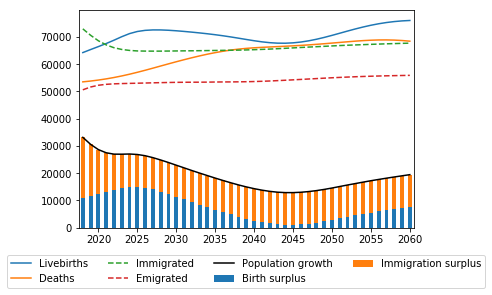

In [180]:
proj_data[['Birth surplus','Immigration surplus']].plot(kind='bar', stacked=True)
proj_data['Livebirths'].plot()
proj_data['Deaths'].plot()
proj_data['Immigrated'].plot(linestyle='dashed')
proj_data['Emigrated'].plot(linestyle='dashed')
proj_data['Population growth'].plot(color='k')
plt.xticks(np.arange(2,len(proj_data),5),aar)
plt.legend(bbox_to_anchor=(0.5, -0.3), loc=8, ncol=4)
plt.show()

Befolkningstal og relativ vækst

In [181]:
proj_data['Relative growth']=proj_data['Population primo'].pct_change()*100
proj_data['Average annual growth (2018-2060)']=((proj_data['Population primo'].iloc[-1]/proj_data['Population primo'].iloc[0])**(1/(2060-2018))-1)*100

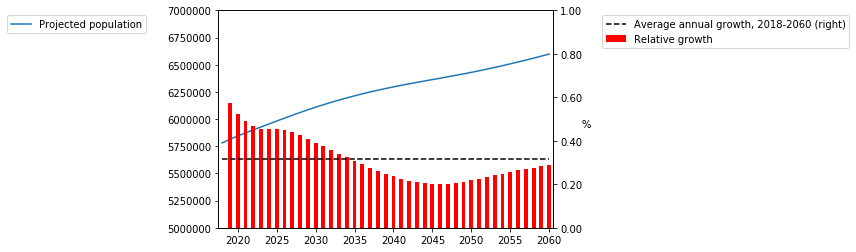

In [182]:
ax1=proj_data[['Relative growth']].plot(kind='bar', secondary_y=True,color='red',legend=False, label='Relative growth (right)')
ax2=proj_data['Average annual growth (2018-2060)'].plot(secondary_y=True,color='black',linestyle='dashed', label='Average annual growth, 2018-2060 (right)')
ax3=proj_data['Population primo'].plot(label = 'Projected population', legend=True)
plt.xticks(np.arange(2,len(proj_data),5),aar)
ax1.set_ylim(0, 1)
ax3.set_ylim(5000000, 7000000)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.get_yaxis().set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_ylabel("%",rotation=0,)
ax3.legend(bbox_to_anchor=(-0.2,1))
ax1.legend(bbox_to_anchor=(1.9,1))

plt.show()

Alderspyramide

In [183]:
agedist = Dst.get_data(table_id = 'FRDK118', variables={'HERKOMST':['*'],'KØN':['*'], 'ALDER':['*'], 'TID':['*']})

In [184]:
age_dist=agedist.groupby(['KØN','ALDER','TID'])['INDHOLD'].sum()
age_dist=age_dist.unstack(level=0)
age_dist.reset_index(inplace=True)
age_dist['Order'] = age_dist['ALDER'].map(lambda x: x.rstrip(' years'))
age_dist['Order']=age_dist['Order'].astype(int)
#age_dist.loc[:, 'Men'] = age_dist['Men'] * -1

In [185]:
alder_list=[0]
next_alder=alder_list[-1]
while next_alder<111:
    next_alder=alder_list[-1]+10
    alder_list.append(next_alder)

In [198]:
def agedist_plot(age_aar):
    agedist_fig=age_dist.loc[age_dist['TID']==age_aar].sort_values(by=['Order'])
    fig, axes = plt.subplots(ncols=2, sharey=False)
    axes[0].barh(agedist_fig['ALDER'], agedist_fig['Men'], align='center', color='blue')
    axes[0].set(title='Men')
    axes[1].barh(agedist_fig['ALDER'], agedist_fig['Women'], align='center', color='Red')
    axes[1].set(title='Women')
    axes[0].invert_xaxis()
    axes[0].set_xlim(50000)
    axes[1].set_xlim(0,50000)
    axes[1].yaxis.tick_right()
    axes[0].set(yticks=np.arange(0,110,10), yticklabels=agedist_fig['ALDER'][0:-2:10])
    axes[1].set(yticks=np.arange(0,110,10), yticklabels=agedist_fig['ALDER'][0:-2:10])
    fig.subplots_adjust(wspace=0)
    fig.suptitle(f'Year: {age_aar}')
    plt.show()
    return 

def interagedist():
    interact(agedist_plot, age_aar = widgets.IntSlider(value=2018, min=2018, max=2058, description='Year:', step=1, disabled=False, continuous=True))
    
def loopagedist():
    for age_aar in range(2020,2061,5):
            display.display(agedist_plot(age_aar=age_aar))
            display.clear_output(wait=True);
            #time.sleep(0.0001)

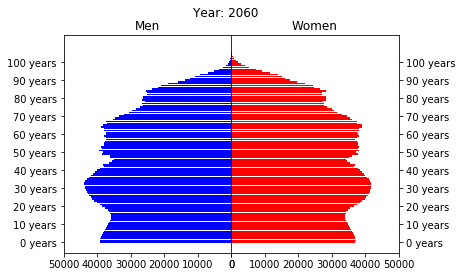

None

In [199]:
loopagedist()

Here we compare the Danish, Swedish and Norwegian population growth towards 2060. Using index

Text(0, 0.5, 'Index 100: 2018')

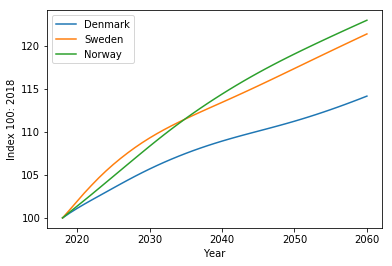

In [200]:
pop_DK=proj_data[['Population primo','TID']];
DK_col={}
DK_col['Population primo'] = 'Danmark'
pop_DK.rename(columns=DK_col, inplace=True)
pop_DK.reset_index(drop=True, inplace=True)
pop_DK.set_index('TID', inplace=True)

pop_SE=pd.read_excel('dataproject/sverige_pop.xlsx', skiprows=2, col=2,nrows=44)
SE_col={}
SE_col['Unnamed: 0'] = 'TID'
SE_col['total'] = 'Sverige'
pop_SE.rename(columns=SE_col, inplace=True)
pop_SE.set_index('TID', inplace=True)

pop_NO=pd.read_excel('dataproject/norge_pop.xlsx', skiprows=3, col=2)
NO_col={}
NO_col['Unnamed: 1'] = 'TID'
NO_col['Population'] = 'Norge'
pop_NO.rename(columns=NO_col, inplace=True)
pop_NO=pop_NO[['TID','Norge']]
pop_NO.set_index('TID', inplace=True)



#pop_SE.head(-1)
#pop_DK.head(10)
#pop_NO.head(10)
popproj_comp=pop_DK.join([pop_SE,pop_NO])
popproj_comp
popind_comp=pd.DataFrame()
popind_comp['Denmark']=popproj_comp['Danmark']/popproj_comp['Danmark'].iloc[0]*100
popind_comp['Sweden']=popproj_comp['Sverige']/popproj_comp['Sverige'].iloc[0]*100
popind_comp['Norway']=popproj_comp['Norge']/popproj_comp['Norge'].iloc[0]*100
popind_comp.index.names = ['Year']
fig3=popind_comp.plot()
fig3.set_ylabel("Index 100: 2018")